In [3]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import neurokit2 as nk

sys.path.append('..')
from util import standardize_signal, normalize_signal, load_base_data, clean_nans

import warnings
warnings.simplefilter("ignore")

plt.rcParams['figure.figsize'] = [20, 5]

In [4]:
DATA_PATH = "../data"
SAMPLING_RATE = 300

In [5]:
X_train, y_train, X_test = load_base_data(data_path=DATA_PATH, just_train=False, flip=True, standard=True)

# Sandbox

y    2
Name: 1000, dtype: int64


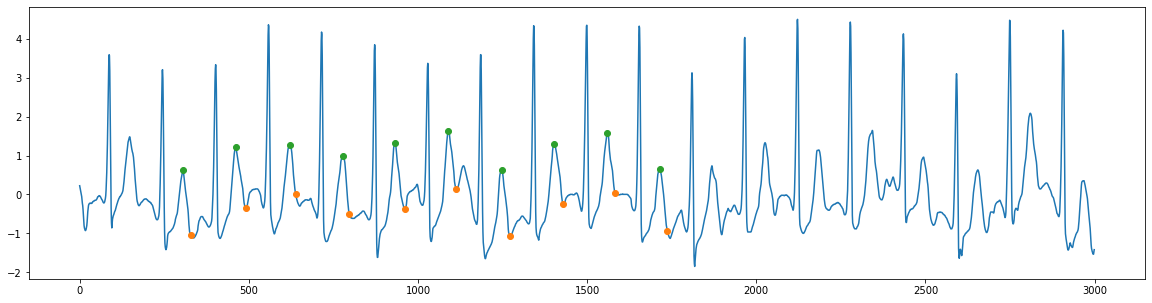

[196, 361, 521, 681, 838, 996, 1134, nan, 1467, nan, 1777, 1935, 2076, 2240, 2404, 2544, 2718, 2857, nan, 3188, nan, 3510, 3666, 3828, 3965, 4144, 4299, 4454, 4615, 4776, 4939, 5096, 5253, 5413, 5580, 5745, 5879, 6072, 6233, 6396, 6563, nan, 6885, 7029, 7194, 7380, 7519, nan, 7862, 8020, 8158, 8322, 8509, 8673]
[ 244  401  558  715  872 1028 1185 1342 1498 1654 1809 1965 2121 2278
 2434 2591 2749 2907 3065 3223 3382 3541 3699 3857 4015 4173 4332 4490
 4649 4808 4969 5129 5290 5451 5613 5776 5938 6101 6264 6427 6591 6755
 6918 7082 7245 7409 7570 7732 7892 8053 8215 8376 8539 8703]


In [16]:
# i = 1497
i = 1000

signal = X_train.loc[i].dropna().to_numpy(dtype='float32')

signals, info = nk.ecg_process(signal, sampling_rate=SAMPLING_RATE)
rpeaks = info["ECG_R_Peaks"]
cleaned_signal = signals["ECG_Clean"]

_, waves_peak = nk.ecg_delineate(cleaned_signal, rpeaks, sampling_rate=SAMPLING_RATE, method="peak")

print(y_train.loc[i])
plt.plot(signal[:3000])
#plt.plot(signal[1000:3000])
plt.plot(waves_peak['ECG_T_Offsets'][:10], signal[waves_peak['ECG_T_Offsets'][:10]], 'o')
plt.plot(waves_peak['ECG_T_Peaks'][:10], signal[waves_peak['ECG_T_Peaks'][:10]], 'o')
# plt.plot(waves_peak['ECG_P_Peaks'][:10], signal[waves_peak['ECG_P_Peaks'][:10]], 'o')
plt.show()

print(waves_peak['ECG_P_Peaks'])
print(rpeaks)
# for key in waves_peak.keys():



In [6]:
waves_peak.keys()

dict_keys(['ECG_P_Peaks', 'ECG_Q_Peaks', 'ECG_S_Peaks', 'ECG_T_Peaks', 'ECG_P_Onsets', 'ECG_T_Offsets'])

In [7]:
# print(len(clean_nans(waves_peak['ECG_Q_Peaks']))/len(rpeaks))
print(waves_peak['ECG_P_Peaks'])
print(signal[waves_peak['ECG_P_Peaks']])

[nan, nan, nan, nan, 643, nan, nan, nan, nan, nan, 1418, nan, nan, nan, nan, nan, nan, nan, 2453, nan, nan, nan, nan, 3105, nan, 3359, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 6342, nan, nan, nan, nan, 6990, nan, 7243, 7382, nan, 7636, nan, nan, nan, 8151, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 10615, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 13990, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 15809, nan, nan, nan, nan, nan, 16579, nan, nan, nan, nan]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [22]:
def process_points(points, signal):
    features = {}
    point_names = ['PO', 'P', 'Q', 'R', 'S', 'T', 'TO']

    # Percentage features
    num_heartbeats = float(len(points['R']))
    features['PO_percent'] = len(clean_nans(points['PO']))/num_heartbeats
    features['P_percent'] = len(clean_nans(points['P']))/num_heartbeats
    features['Q_percent'] = len(clean_nans(points['Q']))/num_heartbeats
    features['S_percent'] = len(clean_nans(points['S']))/num_heartbeats
    features['T_percent'] = len(clean_nans(points['T']))/num_heartbeats
    features['TO_percent'] = len(clean_nans(points['TO']))/num_heartbeats

    
    # X distances
    for i in range(7):
        for j in range(7):
            if i>=j:
                continue
            dists = []
            first_list = points[f'{point_names[i]}']
            sec_list = points[f'{point_names[j]}']
            for k in range(len(first_list)):
                if str(first_list[k]) == 'nan' or str(sec_list[k]) == 'nan':
                    continue
                dists.append(sec_list[k] - first_list[k])
            if len(dists) > 0:
                mean, std, rnge = np.mean(dists), np.std(dists), (np.max(dists) - np.min(dists))
            else:
                mean, std, rnge = None, None, None
            features[f'Xdist_{point_names[i]}{point_names[j]}_mean'] = mean
            features[f'Xdist_{point_names[i]}{point_names[j]}_std'] = std
            features[f'Xdist_{point_names[i]}{point_names[j]}_range'] = rnge

    # Y distances
    for i in range(7):
        for j in range(7):
            if i>=j:
                continue
            dists = []
            first_list = points[f'{point_names[i]}']
            sec_list = points[f'{point_names[j]}']
            for k in range(len(first_list)):
                if str(first_list[k]) == 'nan' or str(sec_list[k]) == 'nan':
                    continue
                dists.append(signal[sec_list[k]] - signal[first_list[k]])
            if len(dists) > 0:
                mean, std, rnge = np.mean(dists), np.std(dists), (np.max(dists) - np.min(dists))
            else:
                mean, std, rnge = None, None, None
            features[f'Ydist_{point_names[i]}{point_names[j]}_mean'] = mean
            features[f'Ydist_{point_names[i]}{point_names[j]}_std'] = std
            features[f'Ydist_{point_names[i]}{point_names[j]}_range'] = rnge

    # Slopes
    for i in range(7):
        for j in range(7):
            if i>=j:
                continue
            slopes = []
            first_list = points[f'{point_names[i]}']
            sec_list = points[f'{point_names[j]}']
            for k in range(len(first_list)):
                if str(first_list[k]) == 'nan' or str(sec_list[k]) == 'nan':
                    continue
                slopes.append((signal[sec_list[k]] - signal[first_list[k]]) / (sec_list[k] - first_list[k]))
            if len(slopes) > 0:
                mean, std, rnge = np.mean(slopes), np.std(slopes), (np.max(slopes) - np.min(slopes))
            else:
                mean, std, rnge = None, None, None
            features[f'Slope_{point_names[i]}{point_names[j]}_mean'] = mean
            features[f'Slope_{point_names[i]}{point_names[j]}_std'] = std
            features[f'Slope_{point_names[i]}{point_names[j]}_range'] = rnge

    return features

In [25]:
def process_dataframe(data):
    feature_vectors = []
    for i in tqdm(range(len(data))):
        signal = data.loc[i].dropna().to_numpy(dtype='float32')
        
        try:
            signals, info = nk.ecg_process(signal, sampling_rate=SAMPLING_RATE)
            rpeaks = info["ECG_R_Peaks"]
            cleaned_signal = signals["ECG_Clean"]
            _, waves_peak = nk.ecg_delineate(cleaned_signal, rpeaks, sampling_rate=SAMPLING_RATE, method="peak")
        except:
            print("Could not run ecg_process.")
            signal = 1-signal
            signals, info = nk.ecg_process(signal, sampling_rate=SAMPLING_RATE)
            rpeaks = info["ECG_R_Peaks"]
            cleaned_signal = signals["ECG_Clean"]
            _, waves_peak = nk.ecg_delineate(cleaned_signal, rpeaks, sampling_rate=SAMPLING_RATE, method="peak")
        
        ecg_points = {
            'PO' : waves_peak['ECG_P_Onsets'],
            'P' : waves_peak['ECG_P_Peaks'],
            'Q' : waves_peak['ECG_Q_Peaks'],
            'R' : rpeaks,
            'S' : waves_peak['ECG_S_Peaks'],
            'T' : waves_peak['ECG_T_Peaks'],
            'TO' : waves_peak['ECG_T_Offsets'],
        }

        morph_features = process_points(ecg_points, signal)
        feature_vectors.append(list(morph_features.values()))

    feature_names =  morph_features.keys()
    return feature_names, feature_vectors

In [26]:
feature_names, feature_vectors = process_dataframe(X_train)

100%|██████████| 5117/5117 [38:16<00:00,  2.23it/s] 


In [27]:
fd_X_train_df = pd.DataFrame(feature_vectors, columns = feature_names)
fd_X_train_df.to_csv("../data/morph_new/X_train.csv", index_label="id")

In [28]:
feature_names_test, feature_vectors_test = process_dataframe(X_test)

 68%|██████▊   | 2325/3411 [17:49<08:07,  2.23it/s]

Could not run ecg_process.


100%|██████████| 3411/3411 [25:48<00:00,  2.20it/s]


In [30]:
len(feature_vectors_test)

3411

In [11]:
fd_X_test_df = pd.DataFrame(feature_vectors_test, columns = feature_names_test)
fd_X_test_df.to_csv("../data/morph_new/X_test.csv", index_label="id")